In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from utils import tokenizer
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, f1_score, precision_score


import warnings
%matplotlib inline
warnings.filterwarnings(action='ignore')

In [2]:
import os
pwd = os.getcwd()
data_path = os.path.join(pwd,'dataset/dga_data.csv')  #pth to dataset
data = pd.read_csv(data_path)
df = data.copy()
df.head()

,isDGA,domain,host,subclass
0,dga,6xzxsw3sokvg1tc752y1a6p0af,6xzxsw3sokvg1tc752y1a6p0af.com,gameoverdga
1,dga,glbtlxwwhbnpxs,glbtlxwwhbnpxs.ru,cryptolocker
2,dga,xxmamopyipbfpk,xxmamopyipbfpk.ru,cryptolocker
3,dga,zfd5szpi18i85wj9uy13l69rg,zfd5szpi18i85wj9uy13l69rg.net,newgoz
4,dga,jpqftymiuver,jpqftymiuver.ru,cryptolocker


In [3]:
subs = [item for item in df['subclass'].unique()]
subs

['gameoverdga',
 'cryptolocker',
 'newgoz',
 'nivdort',
 'goz',
 'necurs',
 'bamital',
 'legit',
 'alexa']

In [4]:
sub_class_counts = pd.DataFrame(df['subclass'].value_counts())
sub_class_counts

,subclass
alexa,42616
legit,37384
cryptolocker,37254
newgoz,9276
gameoverdga,8461
nivdort,8456
necurs,8331
goz,6136
bamital,2086


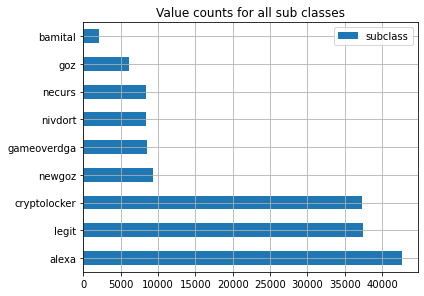

In [5]:
sub_class_counts.plot(kind='barh')
plt.grid(True)
plt.tight_layout()
plt.title('Value counts for all sub classes')
plt.legend()
plt.show()

The distribution of the subclasses value is imbalanced for training and need to be handled

In [6]:
min_value_count = sub_class_counts['subclass'].min()
min_value_count

2086

In [11]:
# balance corpus dataset
def balance_set(df):
      final_host = []
      final_sub_class = []

      for sub in subs:
            host = []
            sub_class = []
           
            temp_host = list(df.loc[df['subclass']==sub,'host'])
            temp_subclass = list(df.loc[df['subclass']==sub,'subclass'])
            host.extend(temp_host)
            sub_class.extend(temp_subclass)

            x,_,y,_ = train_test_split(host,sub_class, train_size=min_value_count-1, random_state=0)
            
            for val_x, val_y in zip(x,y):
                  final_host.append(val_x)
                  final_sub_class.append(val_y)
            
      temp_data = pd.DataFrame({'subclass':final_sub_class, 'host':final_host})
      
      return temp_data

In [16]:
df1 = balance_set(df)
df1

,subclass,host
0,gameoverdga,st7y1mq78azm1cge6vs16yr72j.biz
1,gameoverdga,gh9qxhhcc6ll1ge21n9z1srfz.net
2,gameoverdga,btn5jchc2jw1e1vb9bdfhzv1.net
3,gameoverdga,8qkqvkvqjel01pftrmh12pwt2d.net
4,gameoverdga,1o9hzfl1o45k5u1iz3m9s1w5dhtx.net
...,...,...
18760,alexa,thefreeus.com
18761,alexa,traffic-delivery.com
18762,alexa,nolo.com
18763,alexa,manhunt.net


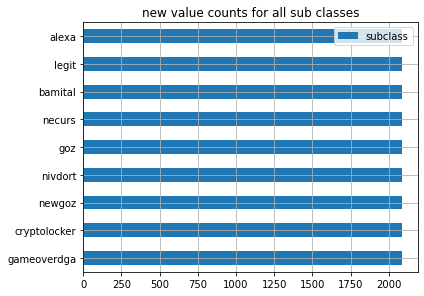

In [14]:
balanced_df = balance_set(df=df)
pd.DataFrame(balanced_df['subclass'].value_counts()).plot(kind='barh')
plt.grid(True)
plt.tight_layout()
plt.title('new value counts for all sub classes')
plt.legend()
plt.show()

In [18]:
df1.isnull().sum()

subclass    0
host        0
dtype: int64

- split data to train and test in 90:10 ratio
- onhot encode target columns
- vectorize train and test X corpus
- build naive bayes model, logistic regression,Random forest moel & ANN
- check metrices for all models
- plot confusion metrics
  

In [24]:
X = df1['host']
y = df1['subclass']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=0)
X_train.shape, y_train.shape

((16888,), (16888,))

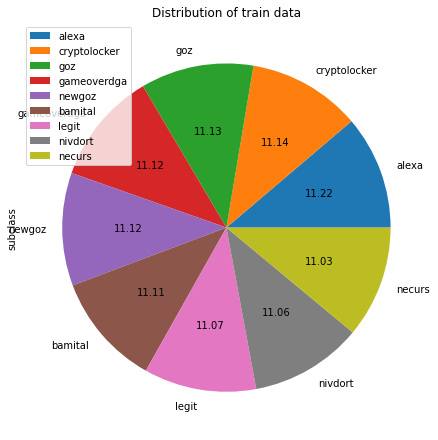

In [47]:
y_data = pd.DataFrame(y_train)
plt.figure(figsize=(20,6))
y_data['subclass'].value_counts().plot(kind='pie', autopct='%.2f')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.title('Distribution of train data')
plt.show()

In [63]:
def encode_feature(data, map):
    le = LabelEncoder()
    features = le.fit_transform(data)
    mappings_dict = {index: label for index, label in enumerate(le.classes_)}
    map.append(mappings_dict)
    return features

In [64]:
mapping = []
mapping_test = []
y_train_onehot = encode_feature(y_train,mapping)
y_test_onehot = encode_feature(y_test, mapping_test)

In [65]:
# Train Data
vectorizer = CountVectorizer(tokenizer=tokenizer)
vectX = vectorizer.fit_transform(X_train)

In [66]:
vect_testX =  vectorizer.transform(X_test)

In [67]:
clf1 = LogisticRegression(random_state=42)
clf1.fit(vectX,y_train_onehot)
pred = clf1.predict(vect_testX)
score = accuracy_score(y_test_onehot, pred)

print(score * 100,'%')

77.67714437932871 %


In [68]:
clf2 =  RandomForestClassifier(max_depth=100, random_state=42)
clf2.fit(vectX,y_train_onehot)
pred = clf2.predict(vect_testX)
score = accuracy_score(y_test_onehot, pred)

print(score * 100,'%')

75.65263718700054 %


In [73]:
clf3 = CategoricalNB()
clf3.fit(vectX,y_train_onehot)
pred = clf3.predict(vect_testX)
score = accuracy_score(y_test_onehot, pred)

print(score * 100,'%')

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [ ]:
# ANN